In [1]:
from rtlsdr import RtlSdr
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
import tqdm
import pandas as pd

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Configure RTL-SDR
sdr = RtlSdr()
sdr.sample_rate = 2.048e6  # 2.048 MHz
sdr.center_freq = 99e6     # 99 MHz (this will be adjusted in the loop)
sdr.gain = 'auto'

# Frequency range
start_freq = 88e6
end_freq = 110e6
step_freq = 1e6
NFFT = 4096

# Store results
frequencies = []
psd_values = []

Detached kernel driver
Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


In [3]:
for freq in tqdm.tqdm(np.arange(start_freq, end_freq, step_freq)):
    sdr.center_freq = freq
    samples = sdr.read_samples(256*1024)
    
    # Calculate PSD
    psd, freqs = plt.psd(samples, NFFT=NFFT, Fs=sdr.sample_rate / 1e6, Fc=sdr.center_freq / 1e6)
    frequencies.extend(freqs)
    psd_values.extend(psd)

# Close the SDR
plt.clf()
sdr.close()

100%|███████████████████████████████████████████| 22/22 [00:04<00:00,  4.48it/s]
Reattached kernel driver


<Figure size 640x480 with 0 Axes>

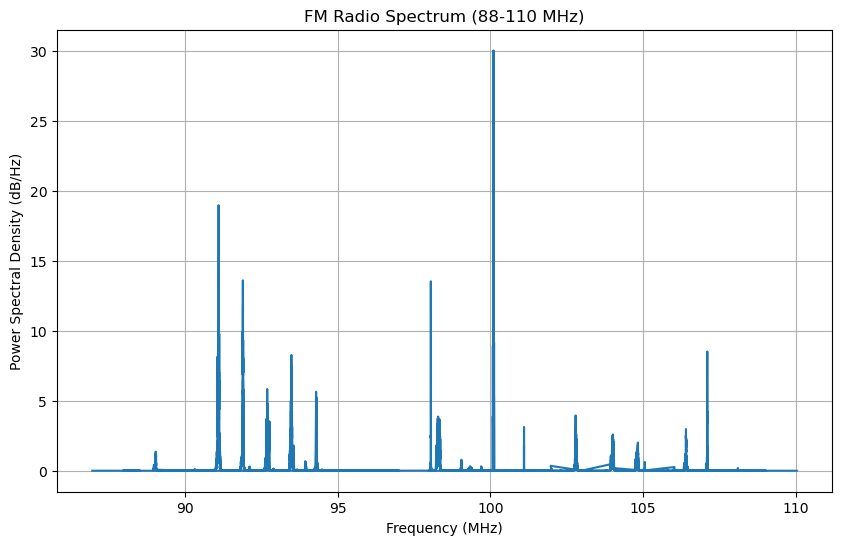

In [4]:
# Convert lists to numpy arrays for easier manipulation
frequencies = np.array(frequencies)
psd_values = np.array(psd_values)
psd_values = np.clip(psd_values, None, 30)

# Plot the spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, psd_values)
plt.title('FM Radio Spectrum (88-110 MHz)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.grid(True)
plt.show()

In [5]:
data = np.dstack((frequencies, psd_values)).reshape(frequencies.shape[0], 2)

In [6]:
data = data[np.argsort(data[:, 0])] 

In [7]:
df = pd.DataFrame(data, columns=["frequency", "psd"])
df.head()

,frequency,psd
0,86.9760,0.000452
1,86.9765,0.000406
2,86.9770,0.000376
3,86.9775,0.000399
4,86.9780,0.000381


In [12]:
thres = 5
for i in range(880, 1100, 1):
    low = i/10 - 0.05
    high = i/10 + 0.05
    max_psd = max(df[(df.frequency > low) & (df.frequency < high)].psd)
    if max_psd > thres:
        print(f"Possible FM Radio station at {i/10} MHz")

Possible FM Radio station at 91.1 MHz
Possible FM Radio station at 91.9 MHz
Possible FM Radio station at 92.7 MHz
Possible FM Radio station at 93.5 MHz
Possible FM Radio station at 94.3 MHz
Possible FM Radio station at 98.1 MHz
Possible FM Radio station at 100.1 MHz
Possible FM Radio station at 107.1 MHz
